# Data Preperation

In [2]:
import pandas as pd
import numpy as np
import glob
import copy
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


In [3]:
countries={ 'Austria': 'AT', 'Belgium': 'BE',  'Bulgaria': 'BG', 'Switzerland': 'CH', 'Czech Republic': 'CZ', 'Germany': 'DE', 'Denmark': 'DK', 'Estonia': 'EE', 'Spain': 'ES', 'Finland': 'FI', 'France': 'FR',  'Greece': 'GR', 'Hungary': 'HU', 'Ireland': 'IE', 'Italy': 'IT', 'Lithuania': 'LT', 'Latvia': 'LV', 'Montenegro': 'ME','Netherlands': 'NL', 'Norway': 'NO', 'Poland': 'PL', 'Portugal': 'PT', 'Serbia': 'RS', 'Sweden': 'SE', 'Slovenia': 'SI', 'Slovakia': 'SK', 'United Kingdom': 'GB'}
abbr_list=list(countries.values())

## Making the first,second,third and fourth columns of the dataframe as date,month,year and time

In [4]:
# In the country speciic Load data set, Austria,Belgium,Germany,Hungary,Netherlands report data every 15 minutes. 
# Therefore, these countries have 35044 data points per year. 
# UK and Ireland report data every 30 minutes henece these countries have 17522 datapoints per year. 
# All the others report every 1 hour hence have 8761 datapoints per year. 
# In Genearion dataset, situation is same as abobe except Belgium reports hourly data hence have 8761 datapoints. 
# In Transmission dataset, all countries report data hourly except Germany which reports every 15 minutes. 
# Due to day light saving, all the datasets have null values on 25th March from 02:00 - 03:00.
# Considering the time intervals each country update the data, a total number of rows of 4,2 or 1 are dropped from the 31st March, 02:00 - 03:00 time interval.
# Also this returns a integer ('divider') based on the file length to get the energy values in a later step. In 15 min interval files this is 4, in 30 min interval files this is 2 and in 1 hour interval files this is 1.

def omit_dst(df):

    length=len(df.index)
    
    if length==35044:
        df = df.drop(range(7976, 7980)).reset_index(drop=True)
        divider=4
    elif length==17522:
        df = df.drop(range(3988, 3990)).reset_index(drop=True)
        divider=2
    else:
        df = df.drop(range(1994, 1995)).reset_index(drop=True)
        divider=1

    return(df,divider)    


# 1. Preparing Data

## 1.1 Preparing Load Data

In [5]:
def load(countries):

    load_dic = {}

    # In the following command we open the csv file of each country and save the data in the 'temp' dataframe. 
    # Then we call the 'omit_dst' function to remove the null data in DST changing date. 
    # Then we call the 'fill_missing_data' function to fill the missing values using the hourly method and weekly method.
    # Then the change the column name to 'demand. 

    # 'groupby' command creates a numpy array with a length similar to the length of the dataframe.
    # Values of the array are obtained by getting the floor division of the length value.
    # For example, when divider=4, this array will be [0,0,0,0,1,1,1,1,2,2,2,2,....].
    # Then the rows of the dataframe will be grouped according to the order of the numpy array with the mean value of those 4 rows.
    # For example, in the numpy array first 4 values are similar. Accordingly first 4 rows of the dataframe will be grouped and get the mean value of those rows

    # Then we save the gap filled csv and update the 'load_dic' dictionary using the 'temp' dataframe.
    
    for country,abbr in countries.items():
        temp,length=omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/Load/{country}.csv').iloc[:, 2:])
        temp, temp_weekly = fill_missing_data(temp, length)
        temp.columns = ['demand']
        temp = temp.groupby(np.arange(len(temp))//length).mean()
        temp_weekly = temp_weekly.groupby(np.arange(len(temp_weekly))//length).mean()

        # temp.to_csv(f'../Data Sources/output/Polynomial Linear Regression/Load/{abbr}.csv')
        # temp_weekly.to_csv(f'../Data Sources/output/Weekly Mean/Load/{abbr}.csv')
        load_dic[abbr] = temp

    return(load_dic)


## 1.2 Preparing Generation Data

In [6]:
def generation(countries):
    
    generation_dic = {}

    # In the following command we open the csv file of each country and save the data in the 'temp' dataframe. 
    # Then we call the 'omit_dst' function to remove the null data in DST changing date.
    # We remove 'Hydro Pumped Storage  - Actual Consumption [MW]' column which is only available in Generation based datasets.
    # We read remove the columns with all n/e values by converting them to 0s
    # Then we call the 'fill_missing_data' function to fill the missing values using the hourly method and weekly method.
    # In the dataset if a whole column consists only with 0 s, such columns are dropped.
    # Then we get the column names of the 'temp' dataframe into a numpy array called 'fuels' and get the column name without the '- Actual Aggregated [MW]' part.
    # Then we change the column names of the dataframe with the edited names in the previous step.
    # Then we save the gap filled csv and update the 'generation_dic' dictionary using the 'temp' dataframe.
        
    for country,abbr in countries.items():
        temp = pd.read_csv(f'../Data Sources/ENTSO-E/2018/Generation/{country}.csv',low_memory=False).iloc[:, 2:]
        temp, length = omit_dst(temp)

        temp = temp.drop(['Hydro Pumped Storage  - Actual Consumption [MW]'], axis=1)
        temp = temp.replace('n/e', 0)
        for column in temp.columns.values:
            if(temp[column] == 0).all():
                temp = temp.drop(column, axis=1)

        temp, temp_weekly = fill_missing_data(temp, length)
        
        for column in temp.columns.values:
            if(temp[column]==0).all():
                temp = temp.drop(column,axis=1)
                temp_weekly = temp_weekly.drop(column, axis=1)

        fuels = [x[:-26] for x in temp.columns.values]
        temp.columns = fuels
        temp_weekly.columns = fuels
        
        temp = temp.groupby(np.arange(len(temp))//length).mean()
        temp_weekly = temp_weekly.groupby(np.arange(len(temp_weekly))//length).mean()

        # temp.to_csv(f'../Data Sources/output/Polynomial Linear Regression/Generation/{abbr}.csv')
        # temp_weekly.to_csv(f'../Data Sources/output/Weekly Mean/Generation/{abbr}.csv')
        generation_dic[abbr] = temp

    return(generation_dic)


## 1.3 Preparing Cross-border Transmission Data

In [7]:
def cross_border():

    transmission_data = pd.DataFrame()
    transmission_data_weekly = pd.DataFrame()

# In the following command we get the list of the paths of all files in the directory. 
# Then we call the 'omit_dst' function to remove the null data in DST changing date.
# Then we rename the two new column in the 'temp' dataframe as the two country codes the power transmission occurs. 
# We use string editing to get the two country codes from the file path. 
# For example, in the power transmission occur between Germany and Austria, we name the column as 'DE -> AT' and if the power transmission occur between Austria and Germany, we name the column as 'AT -> DE '.
# Then we call the 'fill_missing_data' function to fill the missing values using the hourly method and weekly method.
# Then we get all the gap filled transmission data to a single dataframe called 'transmission_data' and save the gap filled csv

    csvs = glob.glob("../Data Sources/ENTSO-E/2018/Transmission/*.csv")

    for csv in csvs:
        temp, length = omit_dst(pd.read_csv(csv).iloc[:, 1:])
        temp = temp.rename(columns={temp.columns[0]: f'{csv[45:47]} - > {csv[42:44]}', temp.columns[1]: f'{csv[42:44]} - > {csv[45:47]}'})
        temp,temp_weekly = fill_missing_data(temp, length)

        temp = temp.groupby(np.arange(len(temp))//length).mean()
        temp_weekly = temp_weekly.groupby(np.arange(len(temp_weekly))//length).mean()
        
        transmission_data = pd.concat([transmission_data, temp], axis=1)
        transmission_data_weekly = pd.concat([transmission_data_weekly, temp_weekly], axis=1)

    # transmission_data.to_csv(f'../Data Sources/output//Polynomial Linear Regression/Transmission/all_transmissions.csv')
    # transmission_data_weekly.to_csv(f'../Data Sources/output/Weekly Mean/Transmission/all_transmissions.csv')

    return transmission_data


# 2. Filling the missing observations in the data

In [8]:
def polynomial(selected_values,selected_index):

    # We get all the indexes in the 'selected_values' to a 2D numpy array 'X'.
    # We get all the values in the 'selected_values'to a 1D numpy array 'y'
    # Then we fill the null values in array 'y' with the mean value of the array.
    # Then we divide 'X' and 'y' values in the ratio of 30% test and 70% train data.
    # We create an array of degree values from 1 to 10.
    # Then we iterate the 'degrees' one by one and create polynomial values of 'x_train' data called 'x_poly_train' based on the value of the degree
    # Then we fit the polynomial linear regression function using 'x_poly_train' data and 'y_train' data.
    # Then based on the polynomial function, using the 'x_poly_test' data we predict the values of the 'y_test' data
    # Then based on the predicted values and 'y_test" data we calculate the Root Mean Square Error.
    # Applying the last 4 steps for each degree value, we select the degree value which gives the Lowest Root Mean Square Error.
    # Then we fit the polynomial linear regression function again using that degree which gives the Lowest Root Mean Square Error.
    # Based on the polynimial function we get the predicted value of the null value.

    # print(selected_values, selected_index)

    X = np.array([i[0] for i in selected_values]).reshape(len(selected_values), 1)
    y = [i[1] for i in selected_values]
    if pd.isnull(y).all():
        mean_value = 0
    else:
        mean_value = np.nanmean(y)
    y = [mean_value if pd.isna(x) else x for x in y]

    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1/3)

    degrees = np.arange(1, 11)
    min_rmse, min_deg = 1e10, 0

    for degree in degrees:

        # Preparing polynomial Train features based on x_train
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        x_poly_train = poly_features.fit_transform(x_train)

        # Polynomial linear regression based on train data
        poly_reg = LinearRegression()
        poly_reg.fit(x_poly_train, y_train)

        # Predicting y values and getting root mean squared error based on predicted y values and y_test values
        x_poly_test = poly_features.fit_transform(x_test)
        poly_predict = poly_reg.predict(x_poly_test)
        poly_mse = mean_squared_error(y_test, poly_predict)
        poly_rmse = np.sqrt(poly_mse)

        # Selecting the best degree of the polynimial function based on lowest root mean squared error
        if min_rmse > poly_rmse:
            min_rmse = poly_rmse
            min_deg = degree

    # Fitting the regression function again based on the selected best degree above
    poly_features = PolynomialFeatures(degree=min_deg, include_bias=False)
    x_poly_train = poly_features.fit_transform(x_train)
    poly_reg = LinearRegression()
    poly_reg.fit(x_poly_train, y_train)

    prediction = poly_reg.predict(poly_features.fit_transform([[selected_index]]))[0]
    if prediction<0:
        prediction = 0
        
    return(prediction)

def mean(selected_values):
    if pd.isnull(selected_values).all():
        prediction = 0

    else:
        mean_value = np.nanmean(selected_values)
        selected_values = [mean_value if pd.isna(x) else x for x in selected_values]
        prediction = np.mean(np.array(selected_values))
    return prediction


In [9]:
def fill_missing_data(df,length):

    df_copy = copy.deepcopy(df)

    # 1. In the following section, we get the indexes and values of a column of a dataframe to a dictionary called 'column_data'.
    # 2. Then we iterate the "column_data" dictionary line by line untill a null value is found (We called this index as 'selected_index').
    # 3. If the index of the value is within the range of after first 3 hours and before the last 3 hours of the column we create a empty list called 'selected_values'.
    # 4. Else if the index is null but it is not in the above range, we get the mean value of first 3 hours or mean value of last 3 hours according to the position of the index of the null value as the missing null value.
    # 5. In 3, We append the 'seleced_values' list with the indexes of the 3 hours before the index of the null value and 3 hours after the index of the null value and respective values of those indexes.
    # 6. In the 6 values of this list if more than 3 are null values and the 'selected_index' is within the range of after first 27 hours and before the last 27 hours of the column we create another empty list called 'selected_values'.
    # 7. Else if more than 3 are null values but not in the range mentioned above, get the mean value of the remaining values in the 'seleced_values' list as the missing null value.
    # 8. If both the two conditions in 6 and 7 are not met, get the missing null value by using the polynomial function.
    # 9. In 6, We append the 'seleced_values' list with the indexes of the (1,2,3,21,22,23,25,26,27) hours before and after the index of the null value and respective values of those indexes.
    # 10. In the 18 values of this llist, if more than 12 are null values and the 'selected_index' is within the range of after first 51 hours and before the last 51 hours of the column we create another empty list called 'selected_values'.
    # 11. Else if more than 12 are null values but not in the range mentioned above, get the mean value of the remaining values in the 'seleced_values' list as the missing null value.
    # 12. If both the two conditions in 10 and 11 are not met, get the missing null value by using the polynomial function.
    # 13. In 10, We append the 'seleced_values' list with the indexes of the (1,2,3,21,22,23,25,26,27,45,46,47,49,50,51) hours before and after the index of the null value and respective values of those indexes.
    # 14. In the 18 values of this llist, if more than 24 are null values and but not all 30 are null values, get the mean value of the remaining values in the 'seleced_values' list as the missing null value.
    # 15. If all 30 are null values, get all the values of that particular time step of that particular day throughout the year (There will be nearly 52 values) and get the missing null value by using the polynomial function.

    for column in df.columns.values:
        column_data = {}
        for index, value in enumerate(df.loc[:, column]):
            column_data[index] = value

        for selected_index, selected_value in column_data.items():

            if pd.isnull(column_data[selected_index]) and selected_index in range(3*length, len(df[column])-3*length):
                selected_values = []
                for i in [x for x in range(-3,4) if x!=0]:
                    selected_values.append([selected_index + i*length,column_data[selected_index + i*length]])
                if pd.isnull(selected_values).sum() >=3 and selected_index in range(27*length, len(df[column])-27*length):
                    selected_values = []
                    for i in [x for x in range(-3, 4) if x != 0]:
                        for j in [-24,0,24]:
                            selected_values.append([selected_index + (i+j)*length,column_data[selected_index + (i+j)*length]])
                    if pd.isnull(selected_values).sum() >= 14 and selected_index in range(51*length, len(df[column])-51*length):
                        selected_values = []
                        for i in [x for x in range(-3, 4) if x != 0]:
                            for j in [-48,-24,0, 24,48]:
                                selected_values.append([selected_index + (i+j)*length,column_data[selected_index + (i+j)*length]])

                        if pd.isnull(selected_values).sum() >= 26 and pd.isnull(selected_values).sum() < len(selected_values):
                            prediction = mean([i[1] for i in selected_values])
                            df.loc[selected_index,column] = prediction

                        elif pd.isnull(selected_values).sum() < 26:
                            prediction = polynomial(selected_values,selected_index)
                            df.loc[selected_index, column] = prediction

                        else:
                            selected_values = [[i,column_data[i]] for i in range(len(df[column])) if (selected_index-i)%(7*24*length) == 0]
                            selected_values.sort(key=lambda x: abs(selected_index - x[0]))
                            selected_values = selected_values[1:]
                            prediction = polynomial(selected_values,selected_index)
                            df.loc[selected_index, column] = prediction

                    elif pd.isnull(selected_values).sum() >= 14:
                        prediction = mean([i[1] for i in selected_values])
                        df.loc[selected_index, column] = prediction

                    else:
                        prediction = polynomial(selected_values,selected_index)
                        df.loc[selected_index, column] = prediction 

                elif pd.isnull(selected_values).sum() >= 3:
                    prediction = mean([i[1] for i in selected_values])
                    df.loc[selected_index, column] = prediction

                else:
                    prediction = polynomial(selected_values, selected_index)
                    df.loc[selected_index, column] = prediction

            elif pd.isnull(column_data[selected_index]) and selected_index < 3*length:
                selected_values =  [[i,column_data[i]] for i in range(6*length)]
                prediction = polynomial(selected_values, selected_index)
                df.loc[selected_index, column] = prediction

            elif pd.isnull(column_data[selected_index]) and selected_index >= (len(df[column])-3*length): 
                selected_values = [[i,column_data[i]] for i in range(len(df[column])-6*length,len(df[column]))]
                prediction = polynomial(selected_values, selected_index)
                df.loc[selected_index, column] = prediction

            # 16. In this 2nd method, the values occured thorughout the year in that day of the week and time of the missing observation are consireded.
            # 17. Then the values are sorted lowest to highest according to the distance to the index of the value from the index of the missing observation.
            # 18. From the sorted values the values related to 7th day, 14th day before and 7th day, 14th day after of the occurence of the missing observation (values 2,3,4,5 in the 'selected_values') are consisdered.
            # 17. These values are sent to 'polynomial' finction to predict the missing observation

            # if pd.isnull(column_data[selected_index]) and selected_index in range(7*24*length, len(df[column])-7*24*length):
            #     prediction = mean([df_copy.loc[selected_index - 7*24*length, column], df_copy.loc[selected_index + 7*24*length, column]])
            #     df_copy.loc[selected_index, column] = prediction
            if pd.isnull(column_data[selected_index]):
                selected_values = [[i,column_data[i]] for i in range(len(df_copy[column])) if (selected_index-i)%(7*24*length) == 0]
                selected_values.sort(key=lambda x: abs(selected_index - x[0]))
                selected_values = selected_values[1:5]
                prediction = polynomial(selected_values, selected_index)
                df_copy.loc[selected_index, column] = prediction
    # df = df.replace(['n/e', np.nan], 0)
    return df, df_copy


# 3. Validating the missing observations filling model

Austria Biomass  - Actual Aggregated [MW]
Austria Fossil Gas  - Actual Aggregated [MW]
Austria Fossil Hard coal  - Actual Aggregated [MW]
Austria Hydro Pumped Storage  - Actual Aggregated [MW]
Austria Hydro Run-of-river and poundage  - Actual Aggregated [MW]
Austria Hydro Water Reservoir  - Actual Aggregated [MW]
Austria Other  - Actual Aggregated [MW]
Austria Solar  - Actual Aggregated [MW]
Austria Waste  - Actual Aggregated [MW]
Austria Wind Onshore  - Actual Aggregated [MW]
Switzerland Hydro Pumped Storage  - Actual Aggregated [MW]
Switzerland Hydro Run-of-river and poundage  - Actual Aggregated [MW]
Switzerland Hydro Water Reservoir  - Actual Aggregated [MW]
Switzerland Nuclear  - Actual Aggregated [MW]
Switzerland Solar  - Actual Aggregated [MW]
Switzerland Wind Onshore  - Actual Aggregated [MW]
Denmark Biomass  - Actual Aggregated [MW]
Denmark Fossil Gas  - Actual Aggregated [MW]
Denmark Fossil Hard coal  - Actual Aggregated [MW]
Denmark Fossil Oil  - Actual Aggregated [MW]
Denma

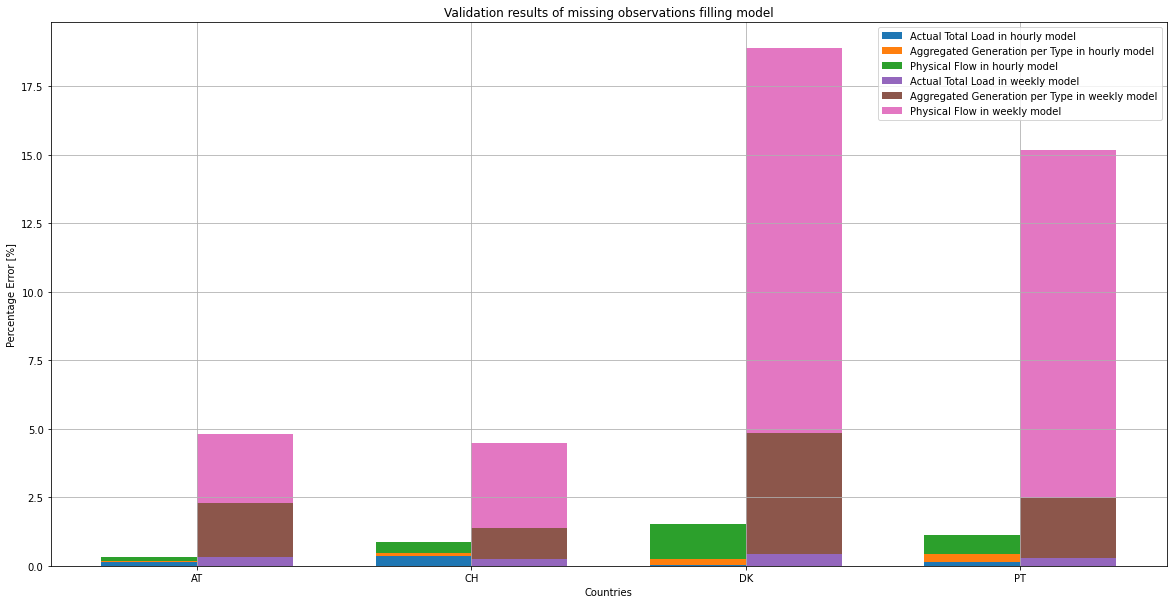

In [17]:
def validation(selected_countries):

    # For the validation only 4 countries are consisdered as they are the countries with the lowest missing observations.
    # First we consider Generation and Load data
    # We read the csv file and send it to 'omit_dst" function and save it as 'df_orig'.
    # We remove 'Hydro Pumped Storage  - Actual Consumption [MW]' column which is only available in Generation based datasets.
    # We remove the columns with all n/e values by converting them to 0s
    # Then we iterate the 'df_orig' column by column and deep copy the column data to to a new variable 'df_column'.
    # Then we create a numpy arrange of  random values  with a number of 10% of the length of the 'df_orig' and save the random numbers in 'values'
    # In the 'df_column' variable, we make the column values null which have the similar indexes as in 'values' variable.
    # Then we send the 'df_column' to the function 'fill_missing_data' to predict the values of the null values we made in the previous step.
    # We use '_hourly' at the end of variable name in the variables related to 'hourly' model and We use '_weekly' at the end of variable name in the variables related to 'weekly' model.
    # We fill the 'filled_values' array with the values predicted in the previous step.
    # We fill any null value in 'df_orig' with 0
    # Then we calcultae the sum of the predicted values and sum of the original values of the predicted values before there were made null.
    # Using these two calculations, percentage error in the predicted values of the country are calculated.

    countries = list(selected_countries.keys())
    gen_load_hourly = {}
    gen_load_weekly = {}
    for country in countries:
        gen_load_hourly[country] = []
        gen_load_weekly[country] = []

    for item in ['Generation','Load']:
        for country in countries:
            sum_orig = 0
            sum_fill_hourly = 0
            sum_fill_weekly = 0
            df_orig, length = omit_dst(pd.read_csv(f'../Data Sources/ENTSO-E/2018/{item}/{country}.csv', low_memory=False).iloc[:, 2:])
            
            if 'Hydro Pumped Storage  - Actual Consumption [MW]' in df_orig.columns.values:
                df_orig = df_orig.drop(['Hydro Pumped Storage  - Actual Consumption [MW]'], axis=1)
            df_orig = df_orig.replace('n/e', 0)
            for column in df_orig.columns.values:
                if(df_orig[column] == 0).all():
                    df_orig = df_orig.drop(column, axis=1)

            for column in df_orig.columns.values:

                df_column = copy.deepcopy(df_orig[[column]])
                values = np.random.randint(low=0, high=8760*length, size=876*length)

                for value in values:
                    df_column.loc[value,column] = np.nan

                df_hourly,df_weekly = fill_missing_data(df_column, length)

                filled_values_hourly=[df_hourly.loc[value,column] for value in values]
                filled_values_hourly = [0 if pd.isna(x) else x for x in filled_values_hourly]
                filled_values_weekly=[df_weekly.loc[value,column] for value in values]
                filled_values_weekly = [0 if pd.isna(x) else x for x in filled_values_weekly]

                df_orig = df_orig.replace(np.nan,0)
                print(country, column)

                sum_orig += sum([df_orig.loc[i, column] for i in values])
                sum_fill_hourly += sum(filled_values_hourly)
                sum_fill_weekly += sum(filled_values_weekly)

            percentage_hourly = round(abs((sum_fill_hourly - sum_orig)*100/sum_orig), 3)
            percentage_weekly = round(abs((sum_fill_weekly - sum_orig)*100/sum_orig), 3)

            gen_load_hourly[country].append(percentage_hourly)
            gen_load_weekly[country].append(percentage_weekly)

    # In the transmission category first we filter the transmission csvs which are relevant only for the 4 countries we consider here.
    # Then for each transmission csv, we carry out the prediction process by randomly making a set values null same as earlier.
    # Similarly as earlier we use '_hourly' at the end of variable name in the variables related to 'hourly' model and We use '_weekly' at the end of variable name in the variables related to 'weekly' model.
    # Then we add the sum of the predicted values and sum of the original values of the predicted values to the two countries where the transmission occurs, if any of the two countries is one of the 4 countries we consider here.

    csvs = glob.glob("../Data Sources/ENTSO-E/2018/Transmission/*.csv")
    countries = list(selected_countries.values())
    selected_csvs= list(set([item for item in csvs for country in countries if country in item[42:47]]))
    tx_hourly = {}
    tx_weekly = {}

    for country in countries:
        tx_hourly[country] = [0, 0]
        tx_weekly[country] = [0, 0]

    for csv in selected_csvs:
        df_orig,length = omit_dst(pd.read_csv(csv, low_memory=False).iloc[:, 1:])

        for column in df_orig.columns.values:

            df_column = copy.deepcopy(df_orig[[column]])
            values = np.random.randint(low=0, high=8760*length, size=876*length)

            for value in values:
                df_column.loc[value, column] = np.nan

            df_hourly,df_weekly = fill_missing_data(df_column, length)

            filled_values_hourly = [df_hourly.loc[value, column] for value in values]
            filled_values_hourly = [0 if pd.isna(x) else x for x in filled_values_hourly]
            filled_values_weekly = [df_weekly.loc[value, column] for value in values]
            filled_values_weekly = [0 if pd.isna(x) else x for x in filled_values_weekly]
            
            df_orig = df_orig.replace(np.nan, 0)
            print(csv[42:44],'-',csv[45:47], column)

            if csv[42:44] in tx_hourly.keys():
                tx_hourly[csv[42:44]][0] += sum([df_orig.loc[i, column] for i in values])
                tx_hourly[csv[42:44]][1] += sum(filled_values_hourly)
                tx_weekly[csv[42:44]][0] += sum([df_orig.loc[i, column] for i in values])
                tx_weekly[csv[42:44]][1] += sum(filled_values_weekly)

            if csv[45:47] in tx_hourly.keys():
                tx_hourly[csv[45:47]][0] += sum([df_orig.loc[i, column] for i in values])
                tx_hourly[csv[45:47]][1] += sum(filled_values_hourly)
                tx_weekly[csv[45:47]][0] += sum([df_orig.loc[i, column] for i in values])
                tx_weekly[csv[45:47]][1] += sum(filled_values_weekly)

    # We get the generation percentage error values of each country to 'generation' variable and load percentage error values of each country to 'load' variable
    # Using the sum of the predicted values and sum of the original values of the predicted values, we calculate percentage error in transmission data of the 4 countries.

    generation_hourly = [x[0] for x in gen_load_hourly.values()]
    load_hourly = [x[1] for x in gen_load_hourly.values()]
    tranasmiision_hourly = [round(abs((value[1]-value[0])*100/value[0]), 2) for value in tx_hourly.values()]
    generation_weekly = [x[0] for x in gen_load_weekly.values()]
    load_weekly = [x[1] for x in gen_load_weekly.values()]
    tranasmiision_weekly = [round(abs((value[1]-value[0])*100/value[0]), 2) for value in tx_weekly.values()]

    #Then we plot the data in a stacked bar graph.

    width = 0.35
    labels = [item for item in tx_hourly.keys()]
    X = np.arange(len(labels))
    plt.figure(figsize=(20, 10))

    bottom_of_tranasmiision_hourly = list(np.add(generation_hourly, load_hourly))
    bottom_of_tranasmiision_weekly = list(np.add(generation_weekly, load_weekly))


    plt.bar([x-width/2 for x in X], load_hourly, width,color = '#1f77b4', label='Actual Total Load in hourly model')
    plt.bar([x-width/2 for x in X],generation_hourly,width,color = '#ff7f0e',bottom=load_hourly,label='Aggregated Generation per Type in hourly model')
    plt.bar([x-width/2 for x in X], tranasmiision_hourly, width,color = '#2ca02c', bottom=bottom_of_tranasmiision_hourly, label='Physical Flow in hourly model')

    plt.bar([x+width/2 for x in X], load_weekly,width,color = '#9467bd', label='Actual Total Load in weekly model')
    plt.bar([x+width/2 for x in X],generation_weekly,width, color = '#8c564b',bottom=load_weekly,label='Aggregated Generation per Type in weekly model')
    plt.bar([x+width/2 for x in X], tranasmiision_weekly, width,color = '#e377c2', bottom=bottom_of_tranasmiision_weekly, label='Physical Flow in weekly model')

    plt.xlabel('Countries')
    # plt.yticks(np.arange(0,2,0.1))
    plt.ylabel('Percentage Error [%]')
    plt.title('Validation results of missing observations filling model')
    plt.xticks(X, labels)
    plt.grid()
    plt.legend()
    plt.show()


# 4. Internal sigma calculation

## 4.1 Sigma calculation

In [11]:
def calculate_sigma(load_data, generation_data, transmission_data, abbr_list):

    eph = 0.1
    lamda=100
    load_gen_data = {}
    sigma = {}

    # First we create a new dictionary called 'load_gen_data' and in that dictionary keys are country_abbreviations and as value of each key we add the combined demand column of each country and generation columns from all the sources in that country.
    # Then in each column we replace the value with 0.1, if the current value is less than 0.1. 
    # Then in each column we change the value as 100/current_value.
    # We save the resultant dataframe as a value in a dictionary called 'sigma' with the key as country_abbreviation.
    # We do the same procedure for transmission_data and save the resultant dataframe as the value of 'transmission_data' key of 'sigma' dictionary.

    for abbr, df in generation_data.items():
        load_gen_data[abbr] = pd.concat([df, load_data[abbr]],axis=1)

    for abbr, df in load_gen_data.items():

        for column in df.columns.values:
            df[column] = df[column].apply(lambda x: eph if x < eph else x)
            df[column] = df[column].apply(lambda x:  lamda/x)
        sigma[abbr] = df

    for transmission in transmission_data.columns.values:
        transmission_data[transmission] = transmission_data[transmission].apply(lambda x: eph if x < eph else x)
        transmission_data[transmission] = transmission_data[transmission].apply(lambda x:  lamda/x)
    sigma["transmission_data"] = transmission_data

    return(sigma)


## 4.2 Internal data consolidation

In [12]:
def data_consolidation(generation_dic, load_dic, transmission_data, intermediary_var, unit_var):
    consolidated_gen_data = {}
    consolidated_load_data = {}
    consolidated_transmission_data = {}

    # In the following command, we fill each generation by source value in each timestep in each country with ('intermediary_var["generation"]' + 'original_value' * 'unit_var['generation]') value of that value
    # Similarly we fill each load value in each timestep in each country with ('intermediary_var['load'] + 'original_value' * 'unit_var['load']') value of that value
    # Then we save the consolidated generation and load values in seperate csv files.
    # We follow similar steps to obtain consolidated transmission values and save the result in a seperate csv file. 

    for abbr, df in generation_dic.items():
        for column in df.columns:
            df[column] = intermediary_var["generation"][abbr][column] + \
                df[column] * unit_var["generation"][abbr][column]
        consolidated_gen_data[abbr] = df
        consolidated_load_data[abbr] = intermediary_var["load"][abbr]['demand'] + \
            load_dic[abbr]['demand'] * unit_var["load"][abbr]['demand']
        consolidated_gen_data[abbr].to_csv(f"../Data Sources/output/Sigma/Generation/{abbr}.csv")
        consolidated_load_data[abbr].to_csv(f"../Data Sources/output/Sigma/Load/{abbr}.csv")

    for column in transmission_data.columns:
        transmission_data[column] = intermediary_var["transmission"][column] + \
            transmission_data[column] * unit_var["transmission"][column]
    consolidated_transmission_data = transmission_data
    consolidated_transmission_data.to_csv('../Data Sources/output/Sigma/Transmission/all_transmissions.csv')

    return(consolidated_gen_data, consolidated_load_data, consolidated_transmission_data)


In [13]:
# sigma(load(countries)[1], generation(countries)[1], cross_border(abbr_list)[1],abbr_list)